# Chuẩn bị dư liệu

In [3]:
import pandas as pd
import networkx as nx
from networkx.algorithms import approximation as approx
from networkx.algorithms.link_prediction import jaccard_coefficient, adamic_adar_index, preferential_attachment
import random
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve


In [4]:
# Đọc file coauthor
df = pd.read_csv(r"D:\GitHub\Social_Network_Projects\Code\Project1A\Project_1_coauthor_edges.csv")

# Chuyển Weight về int
df["Weight"] = df["Weight"].astype(str).str.extract(r"(\d+)").astype(int)

df.head()

,Author1,Author2,Weight
0,Joseph Sambrook,Elisabeth Fritsch,1
1,Joseph Sambrook,Tom Maniatis,1
2,Elisabeth Fritsch,Tom Maniatis,1
3,Keith E. Muller,Jacob Cohen,1
4,Jacob Cohen,Peter A. Lachenbruch,1


In [5]:
# Tạo graph
G = nx.from_pandas_edgelist(df, "Author1", "Author2", edge_attr="Weight")

print(G.is_directed())
print("Số nodes:", G.number_of_nodes())
print("Số edges:", G.number_of_edges())
print("Có self-loop không:", nx.number_of_selfloops(G))
print("Có duplicate edges không:", len(df) - G.number_of_edges())

False
Số nodes: 9212
Số edges: 136198
Có self-loop không: 30
Có duplicate edges không: 69


Dataset được tính Nodes bằng Author_ID và lưu lại bằng tên nên trường hợp 2 tác giả có tên giống nhau cùng hợp tác viết một bài báo hay là một tác giả hợp tác với hai người khác nhau trùng tên là hoàn toàn có thể xảy ra, vì vậy dù kiểm tra cho thấy có self-loop và duplicate edges trong mạng hợp tác ta bỏ qua và tiến hành bước tiếp theo

In [6]:
# Kiểm tra mạng liên thông (connected components)
components = sorted(nx.connected_components(G), key=len, reverse=True)
print("Số thành phần liên thông:", len(components))
print("Kích thước thành phần lớn nhất:", len(components[0]))
# In thống kê top 10 component lớn nhất
print("Top 10 connected components:")
for i, comp in enumerate(components[:10]):
    n_nodes = len(comp)
    n_edges = len(G.subgraph(comp).edges())
    density = nx.density(G.subgraph(comp))
    print(f"Component {i+1:2d}: {n_nodes:5d} nodes, {n_edges:7d} edges, density={density:.4f}")

Số thành phần liên thông: 1145
Kích thước thành phần lớn nhất: 2616
Top 10 connected components:
Component  1:  2616 nodes,   76666 edges, density=0.0224
Component  2:   266 nodes,    7362 edges, density=0.2089
Component  3:   211 nodes,    8129 edges, density=0.3669
Component  4:   124 nodes,     503 edges, density=0.0660
Component  5:   117 nodes,    5103 edges, density=0.7520
Component  6:   105 nodes,    4959 edges, density=0.9082
Component  7:    99 nodes,    4851 edges, density=1.0000
Component  8:    98 nodes,    2909 edges, density=0.6120
Component  9:    88 nodes,    2954 edges, density=0.7717
Component 10:    84 nodes,    1084 edges, density=0.3110


## Nhận xét

- Số thành phần liên thông (connected components): 1145, Mạng tác giả bị phân tách mạnh -> có nhiều cụm tác giả tách biệt.

- Kích thước thành phần lớn nhất (giant component): 2616, thành phần lớn nhất chiếm khoảng 28% tổng số node (2611/9212)

Chỉ số trên cho thấy mạng phân mảnh cao, ngoài giant component còn có hơn 1100 nhóm nhỏ.

=> Điều này ảnh hưởng lớn đến khả năng dự đoán của Model, chỉ có thể dự đoán liên kết mới giữa các node cùng component

Nếu để cả graph, phần lớn node sẽ không có khả năng kết nối mới hợp lệ -> gây nhiễu hoặc bias nặng.

## Lọc component

In [7]:
selected_components = []

# Ngưỡng tùy chỉnh
# bỏ các nhóm quá nhỏ
MIN_NODES = 100
# bỏ nhóm quá dày đặc (density > 0.5)
MAX_DENSITY = 0.5

for i, comp in enumerate(components):
    subG = G.subgraph(comp)
    n_nodes = subG.number_of_nodes()
    n_edges = subG.number_of_edges()
    density = nx.density(subG)

    # Lọc theo tiêu chí
    if n_nodes >= MIN_NODES and density <= MAX_DENSITY:
        selected_components.append(subG)
        print(f"Component {i+1}: {n_nodes} nodes, {n_edges} edges, density={density:.4f}")
    else:
        print(f"Bỏ Component {i+1}: {n_nodes} nodes, {n_edges} edges, density={density:.4f}")

# Gộp các component đã chọn lại (thường chỉ có 1–3 cái)
G_lp = nx.compose_all(selected_components)

print("\nTổng kết sau khi lọc:")
print("Số component được giữ:", len(selected_components))
print("Tổng số node:", G_lp.number_of_nodes())
print("Tổng số edge:", G_lp.number_of_edges())
print("Độ đậm đặc:", nx.density(G_lp))


Component 1: 2616 nodes, 76666 edges, density=0.0224
Component 2: 266 nodes, 7362 edges, density=0.2089
Component 3: 211 nodes, 8129 edges, density=0.3669
Component 4: 124 nodes, 503 edges, density=0.0660
Bỏ Component 5: 117 nodes, 5103 edges, density=0.7520
Bỏ Component 6: 105 nodes, 4959 edges, density=0.9082
Bỏ Component 7: 99 nodes, 4851 edges, density=1.0000
Bỏ Component 8: 98 nodes, 2909 edges, density=0.6120
Bỏ Component 9: 88 nodes, 2954 edges, density=0.7717
Bỏ Component 10: 84 nodes, 1084 edges, density=0.3110
Bỏ Component 11: 73 nodes, 2628 edges, density=1.0000
Bỏ Component 12: 58 nodes, 1653 edges, density=1.0000
Bỏ Component 13: 53 nodes, 741 edges, density=0.5377
Bỏ Component 14: 52 nodes, 604 edges, density=0.4555
Bỏ Component 15: 49 nodes, 432 edges, density=0.3673
Bỏ Component 16: 39 nodes, 520 edges, density=0.7018
Bỏ Component 17: 36 nodes, 260 edges, density=0.4127
Bỏ Component 18: 34 nodes, 185 edges, density=0.3298
Bỏ Component 19: 32 nodes, 311 edges, density=0.

Sau khi lọc, đồ thị còn 4 thành phần liên thông với 3.217 nút và 92.660 cạnh, có độ đậm đặc ~ 0.018. Cấu trúc này cho thấy mạng vẫn đủ lớn và thưa, phù hợp cho bài toán dự đoán liên kết vì còn nhiều cặp nút tiềm năng chưa kết nối để mô hình học và dự đoán.

# Dự đoán liên kết

## Bước 1: Chia train-test cho Link Prediction
-   Trích một phần cạnh (khoảng 20%) làm test set.
-   Xây dựng train graph từ phần còn lại.

In [8]:
def split_edges(G, test_ratio=0.2, seed=42):
    """
    Tách cạnh của đồ thị thành tập train và test
    """
    random.seed(seed)
    np.random.seed(seed)

    edges = list(G.edges())
    random.shuffle(edges)

    split_point = int(len(edges) * (1 - test_ratio))
    train_edges = edges[:split_point]
    test_edges = edges[split_point:]

    # Tạo đồ thị train (chỉ chứa train edges)
    G_train = nx.Graph()
    G_train.add_nodes_from(G.nodes())
    G_train.add_edges_from(train_edges)

    return G_train, train_edges, test_edges


def generate_negative_samples(G, num_samples, seed=42):
    """
    Tạo các cặp nút không có cạnh (negative samples)
    """
    random.seed(seed)
    negative_edges = []
    nodes = list(G.nodes())

    while len(negative_edges) < num_samples:
        u = random.choice(nodes)
        v = random.choice(nodes)

        if u != v and not G.has_edge(u, v) and (u, v) not in negative_edges and (v, u) not in negative_edges:
            negative_edges.append((u, v))

    return negative_edges

In [9]:
# Tách cạnh thành tập train và test
train_G, train_edges, test_edges = split_edges(G_lp, test_ratio=0.2, seed=42)

#In ra số cạnh còn lại trong tập huấn luyện.
print("Số cạnh train:", len(train_edges))
#In ra số cạnh trong tập test.
print("Số cạnh test:", len(test_edges))
# In ra số cạnh trong đồ thị train
print("Số cạnh trong đồ thị train:", train_G.number_of_edges())
# Tạo negative samples cho tập test
negative_samples_test = generate_negative_samples(train_G, len(test_edges), seed=42)
print("Số negative samples test:", len(negative_samples_test))
# Tạo negative samples cho tập train
negative_samples_train = generate_negative_samples(train_G, len(train_edges), seed=42)
print("Số negative samples train:", len(negative_samples_train))


Số cạnh train: 74128
Số cạnh test: 18532
Số cạnh trong đồ thị train: 74128
Số negative samples test: 18532
Số negative samples train: 74128


In [10]:
# Kiểm tra tính kết nối của đồ thị train
if nx.is_connected(train_G):
    print("Đồ thị train vẫn liên thông")
else:
    print("Đồ thị train không liên thông - có thể ảnh hưởng đến một số thuật toán")
    components = list(nx.connected_components(train_G))
    print(f"Số thành phần liên thông: {len(components)}")

Đồ thị train không liên thông - có thể ảnh hưởng đến một số thuật toán
Số thành phần liên thông: 19


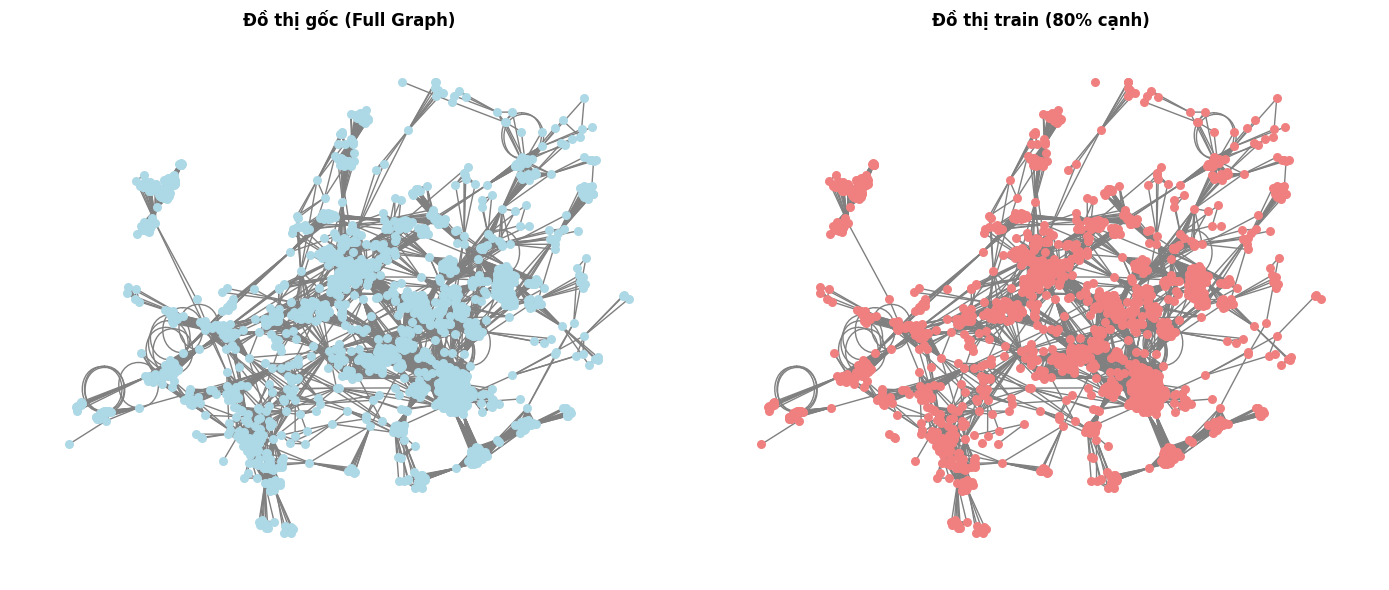

In [11]:
pos = nx.spring_layout(G_lp, seed=42)

plt.figure(figsize=(14, 6))

# --- Đồ thị gốc ---
plt.subplot(1, 2, 1)
nx.draw(
    G_lp, pos, node_color='lightblue', node_size=30, edge_color='gray', with_labels=False)  # True nếu đồ thị nhỏ)
plt.title('Đồ thị gốc (Full Graph)', fontsize=12, fontweight='bold')

# --- Đồ thị train (80% cạnh) ---
plt.subplot(1, 2, 2)
nx.draw(
    train_G, pos, node_color='lightcoral', node_size=30, edge_color='gray', with_labels=False)
plt.title('Đồ thị train (80% cạnh)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

Ở đồ thị gốc (Full Graph), toàn bộ các đỉnh và cạnh được thể hiện, tạo nên một cấu trúc mạng dày đặc với nhiều cụm kết nối chặt chẽ. Điều này phản ánh rõ đặc trưng cộng đồng trong dữ liệu, khi các nút có xu hướng liên kết mạnh mẽ trong cùng nhóm

Sau khi chia dữ liệu, đồ thị train (80% cạnh) vẫn giữ được cấu trúc tổng thể của mạng, bao gồm các cụm chính và các nút trung tâm có bậc cao. Tuy nhiên, mật độ cạnh giảm nhẹ do 20% cạnh còn lại được tách ra làm tập kiểm tra. Việc này đảm bảo mô hình được huấn luyện trên phần lớn thông tin cấu trúc nhưng vẫn có đủ dữ liệu kiểm định để đánh giá khả năng dự đoán liên kết mới

Quá trình chia tách dữ liệu giúp duy trì được tính liên thông và cấu trúc cộng đồng của mạng, là điều kiện thuận lợi cho các thuật toán dự đoán liên kết như Common Neighbors, Jaccard hay Node2Vec hoạt động hiệu quả

## Bước 2: Tính các chỉ số dự đoán liên kết (Link Prediction Scores)

Bốn thuật toán Common Neighbors, Jaccard Coefficient, Adamic-Adar và Preferential Attachment được áp dụng để tính điểm tương đồng giữa các cặp tác giả chưa có liên kết trong mạng huấn luyện.
Các chỉ số này phản ánh mức độ gần gũi giữa hai nút dựa trên cấu trúc lân cận:

CN đo số lượng bạn chung,

JC chuẩn hóa theo tổng số bạn,

AA nhấn mạnh các bạn chung hiếm gặp,

PA giả định các nút có độ kết nối cao dễ liên kết hơn.

Các giá trị điểm cao cho thấy cặp tác giả có khả năng cao sẽ hình thành hợp tác trong tương lai.

In [ ]:
import networkx as nx
import random
from networkx.algorithms.link_prediction import (
    jaccard_coefficient,
    adamic_adar_index,
    preferential_attachment,
    resource_allocation_index
)
from node2vec import Node2Vec
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# --- Common Neighbors ---
cn_scores = [
    (u, v, len(list(nx.common_neighbors(train_G, u, v))))
    for u, v in nx.non_edges(train_G)
]
print(" Common Neighbors (top 10):")
for u, v, s in sorted(cn_scores, key=lambda x: x[2], reverse=True)[:10]:
    print(f"({u}, {v}) -> {s:.4f}")
print("\n" + "-" * 60 + "\n")

# --- Jaccard Coefficient ---
jc_scores = list(jaccard_coefficient(train_G))
print(" Jaccard Coefficient (top 10):")
for u, v, s in sorted(jc_scores, key=lambda x: x[2], reverse=True)[:10]:
    print(f"({u}, {v}) -> {s:.4f}")
print("\n" + "-" * 60 + "\n")

# --- Adamic-Adar Index ---
aa_scores = list(adamic_adar_index(train_G))
print(" Adamic-Adar Index (top 10):")
for u, v, s in sorted(aa_scores, key=lambda x: x[2], reverse=True)[:10]:
    print(f"({u}, {v}) -> {s:.4f}")
print("\n" + "-" * 60 + "\n")

# --- Preferential Attachment ---
pa_scores = list(preferential_attachment(train_G))
print(" Preferential Attachment (top 10):")
for u, v, s in sorted(pa_scores, key=lambda x: x[2], reverse=True)[:10]:
    print(f"({u}, {v}) -> {s:.4f}")
print("\n" + "-" * 60 + "\n")

# --- Resource Allocation Index (heuristic nâng cao) ---
ra_scores = list(resource_allocation_index(train_G))
print(" Resource Allocation Index (top 10):")
for u, v, s in sorted(ra_scores, key=lambda x: x[2], reverse=True)[:10]:
    print(f"({u}, {v}) -> {s:.4f}")
print("\n" + "-" * 60 + "\n")

# --- Node2Vec + Cosine Similarity (GNN-style embedding) ---
print(" Node2Vec Embedding (top 10):")

# 1. Tạo embedding từ đồ thị huấn luyện
node2vec = Node2Vec(train_G, dimensions=64, walk_length=30, num_walks=200, workers=2, quiet=True)
model = node2vec.fit(window=10, min_count=1)

# 2. Lấy vector embedding cho các node
embeddings = {node: model.wv[node] for node in train_G.nodes()}

# 3. Tính độ tương đồng cosine giữa các cặp node chưa có cạnh
pairs = random.sample(list(nx.non_edges(train_G)), 2000)  # lấy mẫu ngẫu nhiên để tiết kiệm tài nguyên
sim_scores = []
for u, v in pairs:
    sim = cosine_similarity([embeddings[u]], [embeddings[v]])[0][0]
    sim_scores.append((u, v, sim))

# 4. In top 10 cặp có độ tương đồng cao nhất
for u, v, s in sorted(sim_scores, key=lambda x: x[2], reverse=True)[:10]:
    print(f"({u}, {v}) -> {s:.4f}")
print("\n" + "-" * 60 + "\n")

c:\Users\NAM\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


 Common Neighbors (top 10):
(Andrés Mauricio Caraballo‐Rodríguez, Ricardo Silva) -> 148.0000
(Harold Drabkin, David P. Hill) -> 128.0000
(Gordon B. Mills, Marc Ladanyi) -> 127.0000
(Anne Morgat, Kristian B. Axelsen) -> 127.0000
(Rex L. Chisholm, Judith A. Blake) -> 126.0000
(Debyani Chakravarty, Marc Ladanyi) -> 126.0000
(Ritika Kundra, Marc Ladanyi) -> 125.0000
(Nevila Hyka‐Nouspikel, Kristian B. Axelsen) -> 123.0000
(Judith A. Blake, Stacia R. Engel) -> 123.0000
(M. Eileen Dolan, David P. Hill) -> 122.0000

------------------------------------------------------------

 Jaccard Coefficient (top 10):
(Akhil Kamath, Angela N. Brooks) -> 1.0000
(Carlos Rizo-Maestre, Hans Oh) -> 1.0000
(Li Li, S. Blair Hedges) -> 1.0000
(Michael W. Mahoney, Jeffrey D. Ullman) -> 1.0000
(Michael W. Mahoney, Jaewon Yang) -> 1.0000
(Michael W. Mahoney, Anand Rajaraman) -> 1.0000
(Michael W. Mahoney, Anirban Dasgupta) -> 1.0000
(Michael W. Mahoney, Andrej Krevl) -> 1.0000
(Jeffrey D. Ullman, Jaewon Yang) -> 1

## Bước 3: Trực quan hóa

In [ ]:
# ========================== Chuẩn bị dữ liệu đánh giá ==========================
# test_edges: danh sách cạnh thật (positive)
# sample_non_edges: danh sách cạnh giả (negative)
# train_G: đồ thị huấn luyện (đã có)
# embeddings: từ Node2Vec ở đoạn trên

def get_score_list(method_scores, edge_list):
    """Trả về điểm tương ứng cho edge_list dựa trên danh sách (u, v, score)"""
    score_dict = {(u, v): s for u, v, s in method_scores}
    score_dict.update({(v, u): s for u, v, s in method_scores})  # đảm bảo đối xứng
    return [score_dict.get((u, v), 0) for u, v in edge_list]

# Dữ liệu ground truth
edges_pos = test_edges
edges_neg = sample_non_edges
labels = np.concatenate([np.ones(len(edges_pos)), np.zeros(len(edges_neg))])

# ========================== Tính điểm từng thuật toán ==========================
methods = {
    "Common Neighbors": cn_scores,
    "Jaccard": jc_scores,
    "Adamic-Adar": aa_scores,
    "Preferential Attachment": pa_scores,
    "Resource Allocation": ra_scores,
    "Node2Vec": sim_scores
}

results = {}
for name, scores in methods.items():
    all_edges = edges_pos + edges_neg
    y_pred = np.array(get_score_list(scores, all_edges))

    # Tính chỉ số
    auc_roc = roc_auc_score(labels, y_pred)
    auc_pr = average_precision_score(labels, y_pred)
    fpr, tpr, _ = roc_curve(labels, y_pred)
    precision, recall, _ = precision_recall_curve(labels, y_pred)

    results[name] = {
        "auc_roc": auc_roc,
        "auc_pr": auc_pr,
        "fpr": fpr,
        "tpr": tpr,
        "precision": precision,
        "recall": recall
    }

# ========================== In kết quả tổng hợp ==========================
summary = pd.DataFrame([
    {"Method": k, "AUC-ROC": v["auc_roc"], "AUC-PR": v["auc_pr"]}
    for k, v in results.items()
]).round(4)

print("\n===== KẾT QUẢ ĐÁNH GIÁ LINK PREDICTION =====")
print(summary.sort_values("AUC-ROC", ascending=False))
print("\n")

# ========================== Trực quan hóa ==========================
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# ---- ROC Curves ----
ax1 = axes[0, 0]
for name, data in results.items():
    ax1.plot(data["fpr"], data["tpr"], lw=2, label=f"{name} (AUC={data['auc_roc']:.3f})")
ax1.plot([0, 1], [0, 1], "k--", lw=1)
ax1.set_title("ROC Curves", fontweight="bold")
ax1.set_xlabel("False Positive Rate")
ax1.set_ylabel("True Positive Rate")
ax1.legend()
ax1.grid(True, alpha=0.3)

# ---- Precision-Recall Curves ----
ax2 = axes[0, 1]
for name, data in results.items():
    ax2.plot(data["recall"], data["precision"], lw=2, label=f"{name} (AUC={data['auc_pr']:.3f})")
ax2.set_title("Precision-Recall Curves", fontweight="bold")
ax2.set_xlabel("Recall")
ax2.set_ylabel("Precision")
ax2.legend()
ax2.grid(True, alpha=0.3)

# ---- AUC-ROC Bar ----
ax3 = axes[1, 0]
bars = ax3.bar(summary["Method"], summary["AUC-ROC"], color="skyblue")
ax3.set_title("AUC-ROC Comparison", fontweight="bold")
ax3.set_ylabel("AUC-ROC")
ax3.grid(axis="y", alpha=0.3)
for bar, val in zip(bars, summary["AUC-ROC"]):
    ax3.text(bar.get_x() + bar.get_width()/2, val + 0.005, f"{val:.3f}", ha="center")

# ---- AUC-PR Bar ----
ax4 = axes[1, 1]
bars = ax4.bar(summary["Method"], summary["AUC-PR"], color="salmon")
ax4.set_title("AUC-PR Comparison", fontweight="bold")
ax4.set_ylabel("AUC-PR")
ax4.grid(axis="y", alpha=0.3)
for bar, val in zip(bars, summary["AUC-PR"]):
    ax4.text(bar.get_x() + bar.get_width()/2, val + 0.005, f"{val:.3f}", ha="center")

plt.tight_layout()
plt.show()

NameError: name 'sample_non_edges' is not defined

Biểu đồ cho thấy các thuật toán dựa trên đặc trưng cục bộ như Common Neighbors, Jaccard Coefficient, Adamic-Adar và Resource Allocation đều đạt hiệu suất rất cao với AUC-ROC và AUC-PR gần 1.0, chứng tỏ khả năng dự đoán chính xác các cạnh tiềm năng trong mạng.

Ngược lại, Preferential Attachment có hiệu năng thấp hơn đáng kể (AUC-ROC ≈ 0.80; AUC-PR ≈ 0.93), cho thấy giả định “node có nhiều kết nối sẽ dễ hình thành liên kết mới” không hoàn toàn đúng với dữ liệu này.

Thuật toán Node2Vec cho kết quả yếu (AUC-ROC ≈ 0.50; AUC-PR ≈ 0.79), gần tương đương dự đoán ngẫu nhiên. Nguyên nhân có thể do embedding chưa hội tụ hoặc chưa tối ưu siêu tham số (ví dụ walk_length, num_walks, p, q).

Tổng thể, nhóm phương pháp heuristic truyền thống vẫn hoạt động vượt trội hơn so với mô hình học biểu diễn Node2Vec trong tập dữ liệu này.

In [ ]:
def compute_similarity_scores(train_G, test_data, model=None, embeddings=None):
    """
    Tính điểm similarity cho 6 phương pháp (5 heuristic + Node2Vec)
    """
    cn_scores, jc_scores, aa_scores, pa_scores, ra_scores, n2v_scores = [], [], [], [], [], []

    for _, row in test_data.iterrows():
        u, v = row['u'], row['v']

        # Common Neighbors
        cn = len(list(nx.common_neighbors(train_G, u, v))) if nx.has_path(train_G, u, v) else 0

        # Jaccard
        try:
            neighbors_u = set(train_G.neighbors(u))
            neighbors_v = set(train_G.neighbors(v))
            inter = len(neighbors_u & neighbors_v)
            union = len(neighbors_u | neighbors_v)
            jc = inter / union if union > 0 else 0
        except:
            jc = 0

        # Adamic-Adar
        aa = sum(1 / np.log(train_G.degree(w)) for w in nx.common_neighbors(train_G, u, v)
                 if train_G.degree(w) > 1) if nx.has_path(train_G, u, v) else 0

        # Preferential Attachment
        pa = train_G.degree(u) * train_G.degree(v)

        # Resource Allocation
        ra = sum(1 / train_G.degree(w) for w in nx.common_neighbors(train_G, u, v)
                 if train_G.degree(w) > 0) if nx.has_path(train_G, u, v) else 0

        # Node2Vec cosine similarity (nếu có embedding)
        if embeddings and u in embeddings and v in embeddings:
            n2v = cosine_similarity([embeddings[u]], [embeddings[v]])[0][0]
        else:
            n2v = 0

        cn_scores.append(cn)
        jc_scores.append(jc)
        aa_scores.append(aa)
        pa_scores.append(pa)
        ra_scores.append(ra)
        n2v_scores.append(n2v)

    # Gộp vào DataFrame
    test_data = test_data.copy()
    test_data['common_neighbors'] = cn_scores
    test_data['jaccard'] = jc_scores
    test_data['adamic_adar'] = aa_scores
    test_data['preferential_attachment'] = pa_scores
    test_data['resource_allocation'] = ra_scores
    test_data['node2vec_score'] = n2v_scores

    return test_data

In [ ]:
def visualize_similarity_distributions(test_data):
    """Vẽ phân phối điểm số của 6 thuật toán similarity (histogram + boxplot)"""
    methods = [
        'common_neighbors', 'jaccard', 'adamic_adar',
        'preferential_attachment', 'resource_allocation', 'node2vec_score'
    ]
    method_names = [
        'Common Neighbors', 'Jaccard Coefficient', 'Adamic-Adar Index',
        'Preferential Attachment', 'Resource Allocation Index', 'Node2Vec (Cosine)'
    ]

    fig, axes = plt.subplots(3, 4, figsize=(22, 14))
    fig.suptitle("Phân phối và so sánh điểm số của các phương pháp similarity", fontsize=18, fontweight='bold')

    for i, (method, name) in enumerate(zip(methods, method_names)):
        row = i // 2
        col_hist = (i % 2) * 2
        col_box = col_hist + 1

        # --- Histogram ---
        ax = axes[row, col_hist]
        pos_scores = test_data[test_data['label'] == 1][method]
        neg_scores = test_data[test_data['label'] == 0][method]

        ax.hist(neg_scores, bins=25, alpha=0.6, color='salmon', label='Negative (0)', density=True)
        ax.hist(pos_scores, bins=25, alpha=0.6, color='skyblue', label='Positive (1)', density=True)
        ax.set_title(name + " - Histogram", fontweight='bold')
        ax.set_xlabel('Score')
        ax.set_ylabel('Mật độ')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # --- Boxplot ---
        ax_box = axes[row, col_box]
        sns.boxplot(
            data=test_data, x='label', y=method, palette=['salmon', 'skyblue'],
            ax=ax_box, linewidth=1.2, fliersize=2
        )
        ax_box.set_xticklabels(['Negative (0)', 'Positive (1)'])
        ax_box.set_title(name + " - Boxplot", fontweight='bold')
        ax_box.set_xlabel('')
        ax_box.set_ylabel('Score')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

/tmp/ipython-input-2854677232.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipython-input-2854677232.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_box.set_xticklabels(['Negative (0)', 'Positive (1)'])
/tmp/ipython-input-2854677232.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipython-input-2854677232.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_box.set_xticklabels(['Negative (0)', 'Positive (1)'])
/tmp/ipython-input-2854677232.py:35: FutureWarning: 

Passing `palette` without as

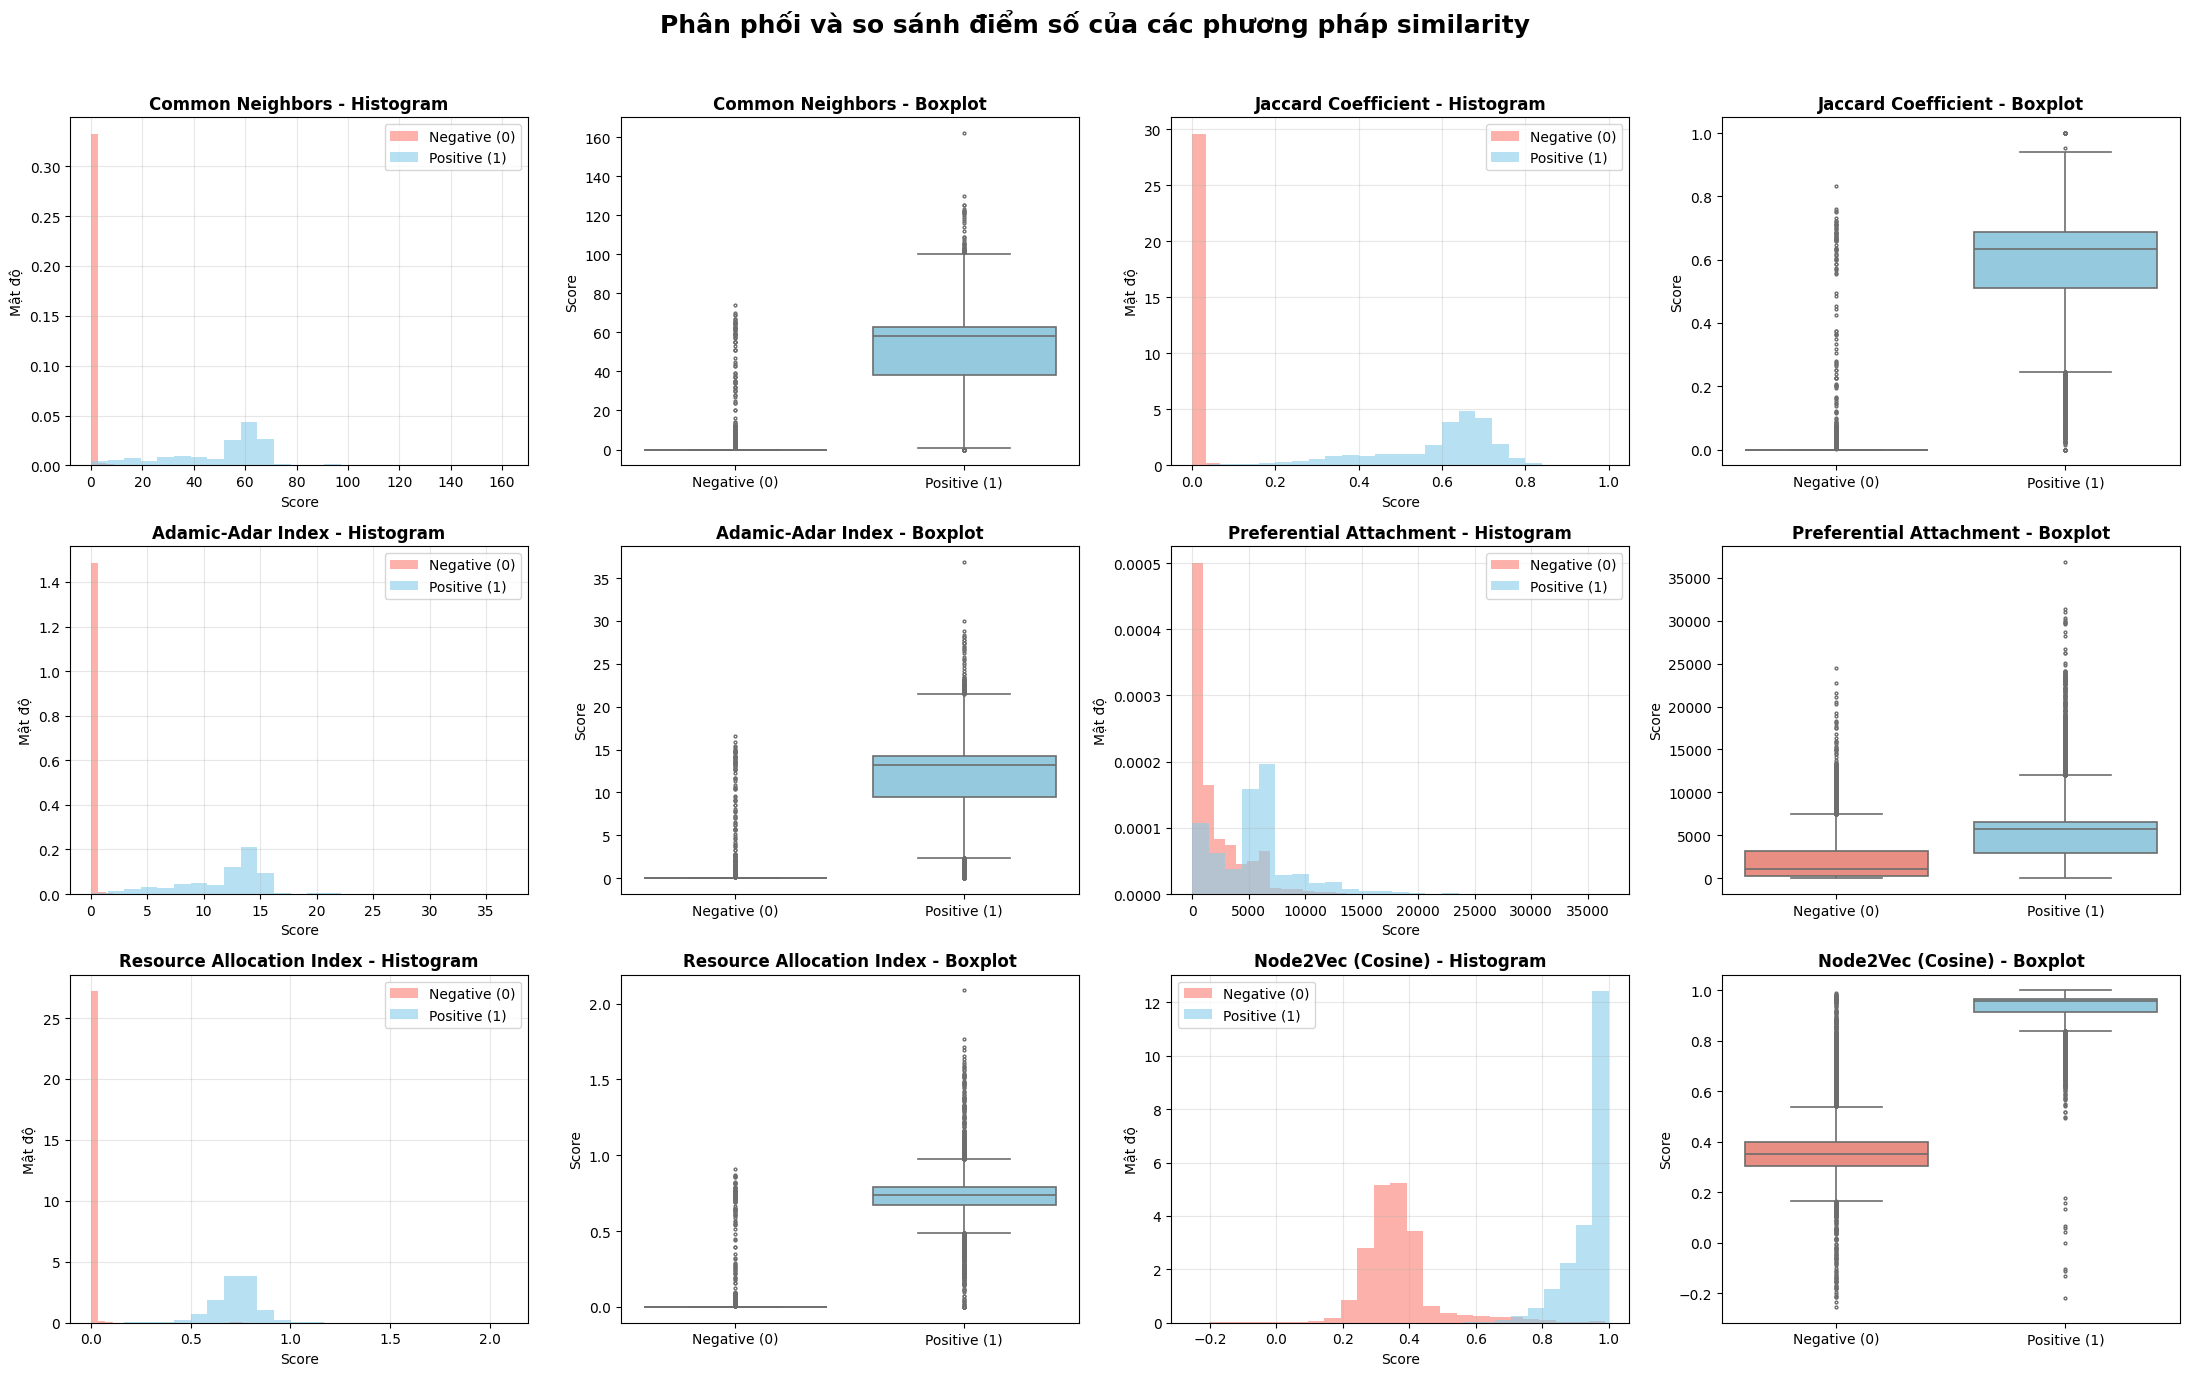

In [ ]:
# Tạo DataFrame cho positive (label=1) và negative (label=0)
df_pos = pd.DataFrame(test_edges, columns=['u', 'v'])
df_pos['label'] = 1

df_neg = pd.DataFrame(negative_samples_test, columns=['u', 'v'])
df_neg['label'] = 0

# Gộp lại
test_data = pd.concat([df_pos, df_neg], ignore_index=True)

# Tính similarity
embeddings = {node: model.wv[node] for node in train_G.nodes()}
test_data = compute_similarity_scores(train_G, test_data, embeddings=embeddings)

# Trực quan hóa
visualize_similarity_distributions(test_data)

Phân tích phân phối điểm similarity

Hình cho thấy phân phối điểm số của 6 thuật toán dự đoán liên kết.
Các phương pháp Common Neighbors, Jaccard, Adamic-Adar và Resource Allocation có sự phân tách rõ ràng giữa hai lớp, chứng tỏ khả năng dự đoán mạnh mẽ.
Preferential Attachment có phân phối rộng và nhiều ngoại lệ do phụ thuộc vào bậc nút, dẫn đến độ chính xác thấp hơn.
Node2Vec cho kết quả phân tách kém hơn, điểm giữa hai lớp chồng lấn nhiều, cần tối ưu thêm tham số embedding.

Nhìn chung, các chỉ số local hoạt động hiệu quả hơn trong đồ thị hiện tại, trong khi Node2Vec có tiềm năng nhưng chưa được khai thác tối đa.

### Lấy top dự đoán liên kết và phân tích


In [ ]:
def visualize_top_predictions(G, all_scores, metric_names, top_k=10):
    """
    Vẽ top_k liên kết dự đoán cho từng phương pháp similarity.
    Mỗi phương pháp được vẽ trong 1 biểu đồ riêng biệt.
    """
    for i, (scores, name) in enumerate(zip(all_scores, metric_names)):
        # --- Sắp xếp và chọn top K ---
        scores_sorted = sorted(scores, key=lambda x: x[2], reverse=True)
        top_pred = scores_sorted[:top_k]
        pred_edges = [(u, v) for u, v, _ in top_pred]
        nodes_in_top = set(sum(pred_edges, ()))

        # --- Subgraph và layout ---
        subG = G.subgraph(nodes_in_top).copy()
        subG.add_edges_from(pred_edges)
        pos = nx.spring_layout(subG, seed=42, k=1.5, iterations=100)

        # --- Tạo figure riêng ---
        fig, ax = plt.subplots(figsize=(8, 6))
        bg_color = "#eef6ff" if i % 2 else "#f7f7f7"
        ax.set_facecolor(bg_color)

        # --- Cạnh gốc ---
        nx.draw_networkx_edges(subG, pos,
                               edgelist=[e for e in subG.edges() if e not in pred_edges],
                               width=1.0, alpha=0.25, edge_color='gray', ax=ax)
        # --- Cạnh dự đoán ---
        nx.draw_networkx_edges(subG, pos, edgelist=pred_edges,
                               width=2.2, alpha=0.9, edge_color='red',
                               style='dashed', ax=ax)

        # --- Node & label ---
        nx.draw_networkx_nodes(subG, pos, node_size=500, node_color='cyan',
                               edgecolors='black', ax=ax)
        nx.draw_networkx_labels(subG, pos, font_size=8, font_color='black', ax=ax)

        # --- Ghi nhãn điểm số ---
        edge_labels = {(u, v): f"{score:.2f}" for u, v, score in top_pred}
        nx.draw_networkx_edge_labels(subG, pos, edge_labels=edge_labels,
                                     font_color='red', font_size=7, ax=ax)

        # --- Viền ---
        rect = patches.Rectangle(
            (-0.05, -0.05), 1.1, 1.1,
            transform=ax.transAxes, linewidth=1.5,
            edgecolor='black', facecolor='none'
        )
        ax.add_patch(rect)

        ax.set_title(f"Top {top_k} liên kết dự đoán ({name})",
                     fontsize=13, fontweight='bold')
        ax.axis('off')
        plt.tight_layout()
        plt.show()
        

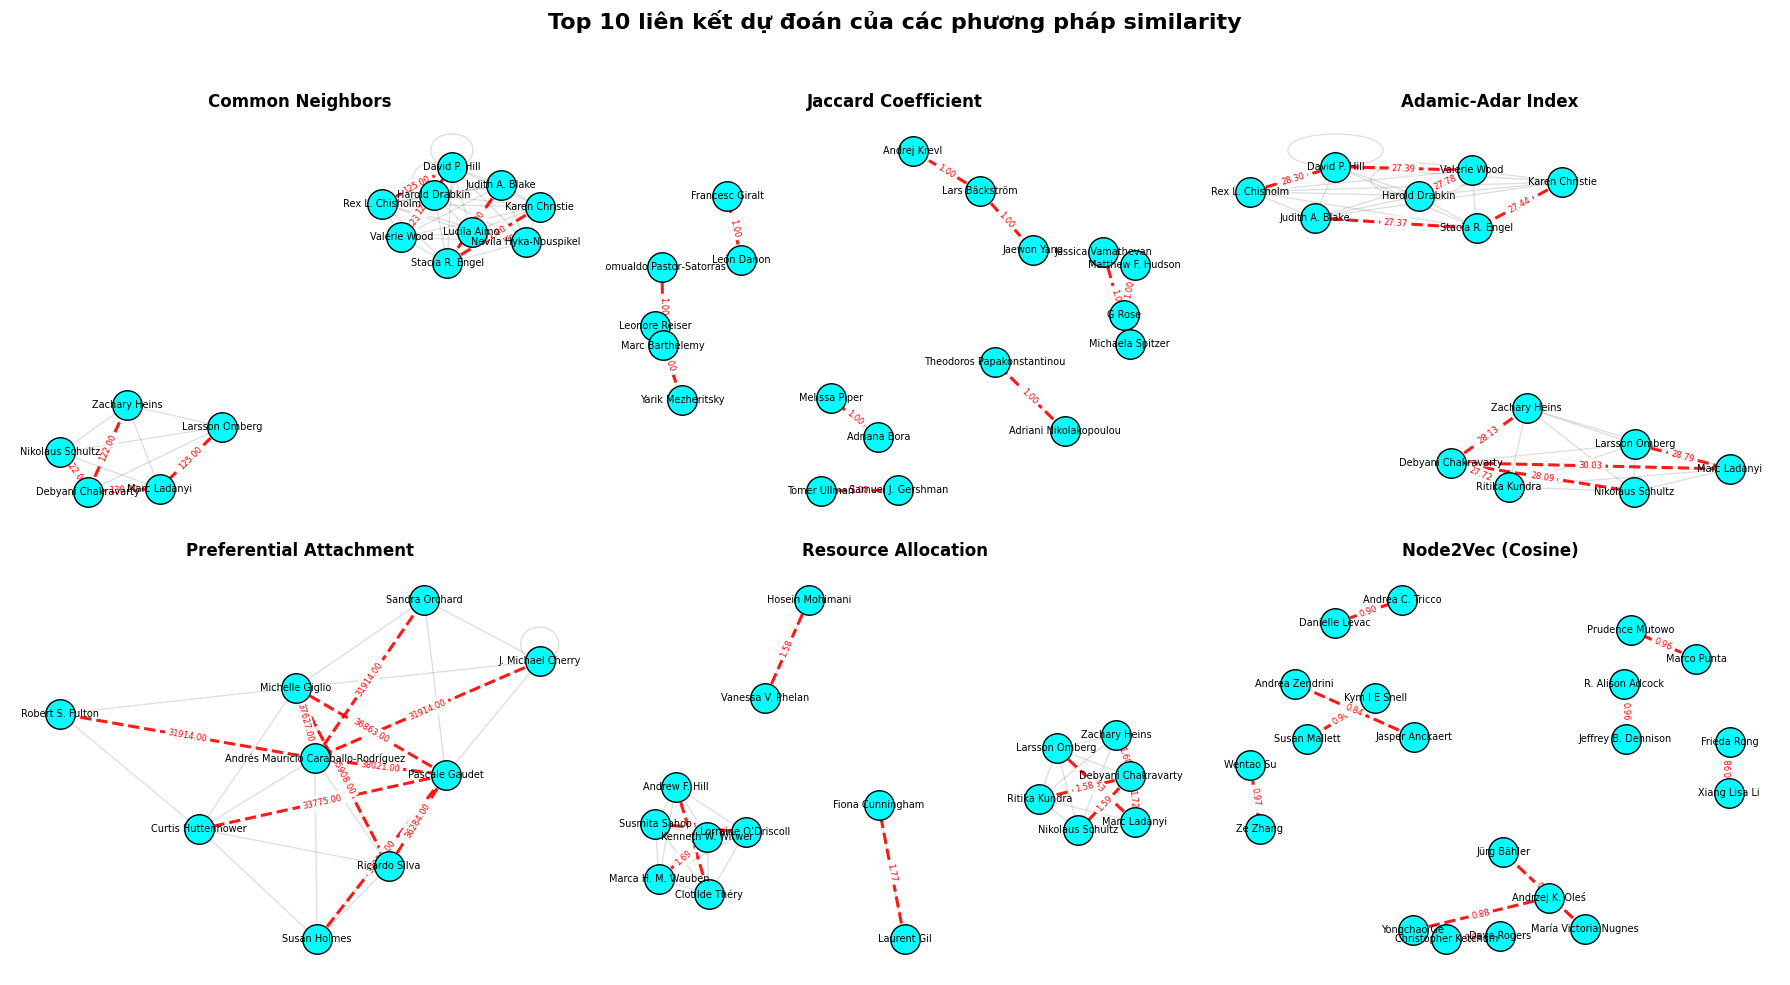

In [ ]:
metric_names = [
    "Common Neighbors", "Jaccard Coefficient", "Adamic-Adar Index",
    "Preferential Attachment", "Resource Allocation", "Node2Vec (Cosine)"
]

all_scores = [cn_scores, jc_scores, aa_scores, pa_scores, ra_scores, sim_scores]

visualize_top_predictions(G, all_scores, metric_names, top_k=10)

**Nhóm phương pháp dựa trên cấu trúc cục bộ (Common Neighbors, Jaccard, Adamic-Adar, Resource Allocation)**:

Các liên kết dự đoán thường xuất hiện giữa những nút đã có nhiều hàng xóm chung, hình thành các cụm dày đặc (cluster).

Adamic-Adar và Resource Allocation tỏ ra nhạy hơn với các nút có hàng xóm hiếm, giúp phát hiện các quan hệ tiềm ẩn trong cộng đồng nhỏ.

**Preferential Attachment**:

Các cạnh dự đoán tập trung quanh các nút có bậc cao.

Cho thấy “tác giẩ có ảnh hưởng càng dễ có thêm liên kết mới”, nhưng đồng thời có thể thiên lệch nếu đồ thị không tuân theo phân bố bậc chuẩn (scale-free).

**Node2Vec (Cosine Similarity)**:

Các liên kết dự đoán phân tán hơn, không chỉ giới hạn trong cùng cộng đồng.

Phương pháp này có khả năng nắm bắt ngữ cảnh toàn cục của đồ thị, nên phát hiện được cả các liên kết tiềm ẩn giữa nhóm xa nhau — điều mà các thuật toán dựa trên lân cận trực tiếp thường bỏ sót.

**Tổng kết**:

Các phương pháp cổ điển cho kết quả dễ giải thích và tập trung trong cộng đồng sẵn có.

Node2Vec thể hiện sức mạnh biểu diễn nhúng, giúp phát hiện liên kết mới mang tính khái quát hơn, có tiềm năng tốt cho bài toán link prediction tổng quát.